# Follow-the-Leader (FTL) strategy

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
key = jax.random.PRNGKey(3141)
key_oracle, key_agent = jax.random.split(key, 2)

T = 2000 # 500
y = jax.random.uniform(key_oracle, (T,), minval=0, maxval=1)
y = jax.random.bernoulli(key_oracle, p=0.4, shape=(T,))
y = jax.random.beta(key_oracle, a=0.5, b=0.5, shape=(T,))

In [4]:
y = jnp.arange(T) % 2

y

Array([0, 1, 0, ..., 1, 0, 1], dtype=int32)

In [5]:
trange = jnp.arange(T)
@partial(jax.vmap, in_axes=(0, None, None, None))
def regret_step(t, yseq, xseq, trange):    
    yseq = yseq + (trange > t) * jnp.nan
    x_agent = xseq + (trange > t) * jnp.nan
    x_oracle = jnp.nanmean(yseq)
    
    regret = jnp.nansum((x_agent - yseq) ** 2)
    regret = regret - jnp.nansum((x_oracle - yseq) ** 2)
    
    return regret

In [6]:
x_ftl = y.cumsum() / (1 + trange)
x_ftl = jnp.roll(x_ftl, 1)
x_ftl = x_ftl.at[0].set(0)

regret = regret_step(trange[1:], y[1:], x_ftl[1:], trange[1:])

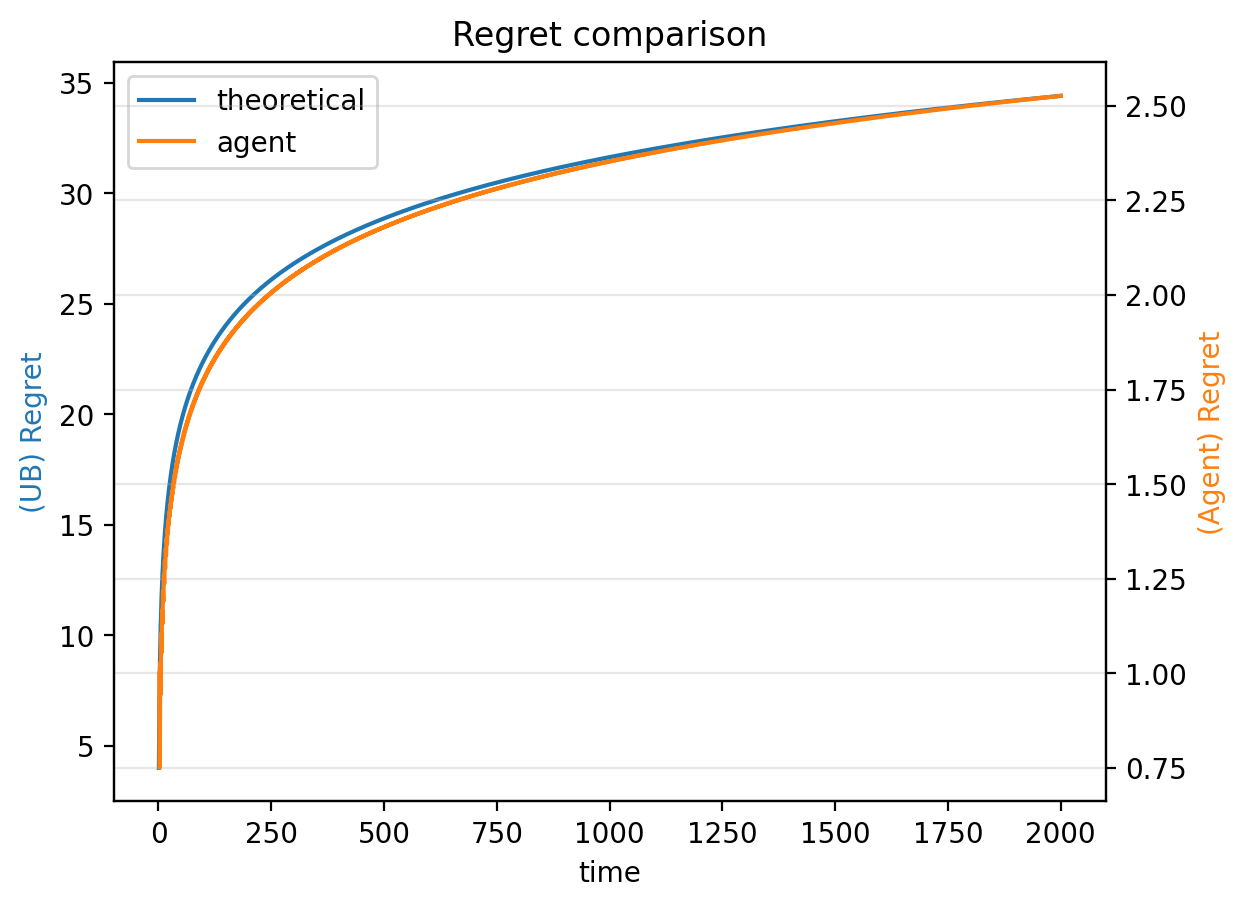

In [15]:
trange = jnp.arange(1, T+1)
ubound = 4 + 4 * jnp.log(trange)

fig, ax = plt.subplots()
ax2 = ax.twinx()

l1 = ax.plot(trange, ubound, label="theoretical")
l2 = ax2.plot(trange[1:], regret, label="agent", c="tab:orange")

ax.yaxis.label.set_color("tab:blue")
ax2.yaxis.label.set_color("tab:orange")

lines = l1 + l2
labels = [l.get_label() for l in lines]

ax.set_ylabel("(UB) Regret")
ax2.set_ylabel("(Agent) Regret")
ax.set_xlabel("time")
ax.legend(lines, labels)
plt.title("Regret comparison")
plt.grid(alpha=0.3)